In [83]:
using Gen
using Distributions
using Random
using Plots
using Statistics
using GenParticleFilters

# Model

In [84]:
# Some constants
const dt = 0.1         # Simulation fidelty
const LANDMARK_X = 3.0 # Landmark position
const LANDMARK_Y = 3.0

3.0

In [85]:
@gen function robot_localization_model(
    dt::Float64,
    controls::Matrix{Float64},
    T::Int,                    
    sigma_v::Float64,          
    sigma_omega::Float64,       
    sigma_obs::Float64,
    sigma_theta::Float64       # NEW: heading observation noise (compass/IMU)
)
    # Initial pose
    x = @trace(normal(0.0, 10.0), :x0)
    y = @trace(normal(0.0, 10.0), :y0)
    theta = @trace(normal(0.0, 3.0), :theta0)
    
    # Range to landmark
    range0 = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
    @trace(normal(range0, sigma_obs), (:obs, 0))
    
    # NEW: Heading observation (compass/IMU)
    @trace(normal(theta, sigma_theta), (:obs_theta, 0))
    
    for t in 1:T        
        # Odometry readings will be noisy
        v_noisy = @trace(normal(controls[t, 1], sigma_v), (:v_noise, t))
        omega_noisy = @trace(normal(controls[t, 2], sigma_omega), (:omega_noise, t))
        
        # Update pose
        theta = rem2pi(theta + omega_noisy * dt, RoundNearest)
        x = x + v_noisy * cos(theta) * dt
        y = y + v_noisy * sin(theta) * dt
        
        # Range observation
        expected_range = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
        @trace(normal(expected_range, sigma_obs), (:obs, t))
        
        # NEW: Heading observation
        @trace(normal(theta, sigma_theta), (:obs_theta, t))
    end
    
    return (x, y, theta)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Matrix{Float64}, Int64, Float64, Float64, Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing], Main.var"##robot_localization_model#491", Bool[0, 0, 0, 0, 0, 0, 0], false)

In [86]:
# Example impulse control generation. In a real-world setting we would first collect this data from the robot
# controls and then read it into the program rather than simulate it.
Random.seed!(419)

T = 100
sigma_v = 0.05
sigma_omega = 0.03
sigma_obs = 0.3
sigma_theta = 0.1  # NEW: heading observation noise (compass/IMU, ~6 degrees)
controls = zeros(T, 2)
turn_bias = 0.0

for t in 1:T
    # Occasionally change turn direction
    if t % 7 == 1 || rand() < 0.15
        turn_bias = randn() * 1.5
    end
    v = 0.35 + 0.1 * randn()
    omega = turn_bias + 0.8 * randn()
    controls[t, 1] = clamp(v, 0.2, 0.5)
    controls[t, 2] = clamp(omega, -2.0, 2.0)
end

In [87]:
# Generate a trace from the model (now with heading observations)
(trace, _) = generate(robot_localization_model, (dt, controls, T, sigma_v, sigma_omega, sigma_obs, sigma_theta))

# Extract ground truth initial state
x0_true = trace[:x0]
y0_true = trace[:y0]
theta0_true = trace[:theta0]

# Extract observations
observations = [trace[(:obs, t)] for t in 0:T]
observations_theta = [trace[(:obs_theta, t)] for t in 0:T]  # NEW: heading observations

println("Initial pose")
println("x0 = $(round(x0_true, digits=3))")
println("y0 = $(round(y0_true, digits=3))")
println("θ0 = $(round(theta0_true, digits=3)) rad")

println("\nObservations (range + heading)")
for t in 0:25:T
    println("t=$t: range=$(round(observations[t+1], digits=2))m, θ=$(round(observations_theta[t+1], digits=2))rad")
end

Initial pose
x0 = -1.015
y0 = 0.528
θ0 = -1.205 rad

Observations (range + heading)
t=0: range=4.84m, θ=-1.27rad
t=25: range=5.2m, θ=-0.76rad
t=50: range=4.29m, θ=2.83rad
t=75: range=5.06m, θ=-2.82rad
t=100: range=5.86m, θ=2.89rad


In [88]:
# A naive function to reconstruct trajectory from observations. This just
# uses noisy observations, accumulating error.
function simulate_trajectory(trace, controls, T)
    # List of estimated poses 
    poses = zeros(T+1, 3)
    
    # Initial pose
    x = trace[:x0]
    y = trace[:y0]
    theta = trace[:theta0]
    poses[1, :] = [x, y, theta]
    
    for t in 1:T
        theta = rem2pi(theta + trace[(:omega_noise, t)] * dt, RoundNearest)
        x = x + trace[(:v_noise, t)] * cos(theta) * dt
        y = y + trace[(:v_noise, t)] * sin(theta) * dt
        poses[t+1, :] = [x, y, theta]
    end
    
    return poses
end

simulate_trajectory (generic function with 1 method)

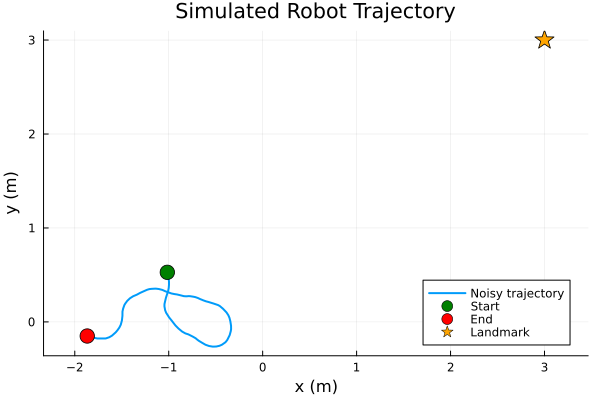

In [89]:
true_poses = simulate_trajectory(trace, controls, T)

# Plot the noisy trajectory
p = plot(
    true_poses[:, 1], true_poses[:, 2],
    label="Noisy trajectory",
    xlabel="x (m)", ylabel="y (m)",
    title="Simulated Robot Trajectory",
    linewidth=2,
    aspect_ratio=:equal,
    legend=:bottomright
)

# Mark start, end, and landmark
scatter!(p, [true_poses[1, 1]], [true_poses[1, 2]], label="Start", markersize=8, color=:green)
scatter!(p, [true_poses[end, 1]], [true_poses[end, 2]], label="End", markersize=8, color=:red)
scatter!(p, [LANDMARK_X], [LANDMARK_Y], label="Landmark", markersize=10, markershape=:star5, color=:orange)

display(p)

# Baselines

In [90]:
# Setup: Create observation constraints (range + heading)
obs_constraints = choicemap()
for t in 0:T
    obs_constraints[(:obs, t)] = observations[t+1]
    obs_constraints[(:obs_theta, t)] = observations_theta[t+1]  # NEW: heading observations
end

println("Ground truth initial pose:")
println("x0 = ", round(x0_true, digits=3))
println("y0 = ", round(y0_true, digits=3))
println("θ0 = ", round(theta0_true, digits=3))

Ground truth initial pose:
x0 = -1.015
y0 = 0.528
θ0 = -1.205


# MH Baseline

In [91]:
# Metropolis-Hastings with BLOCKED UPDATES (fair - also updates noise path)
# Must update both pose AND noise variables since noise is not constrained
Random.seed!(420)

(current_trace, _) = generate(robot_localization_model, (dt, controls, T, sigma_v, sigma_omega, sigma_obs, sigma_theta), obs_constraints)

# Selection for pose parameters
pose_sel = select(:x0, :y0, :theta0)

# Function to create selection for a subset of noise timesteps
function noise_sel(ts)
    addrs = Any[]
    for t in ts
        push!(addrs, (:v_noise, t))
        push!(addrs, (:omega_noise, t))
    end
    return select(addrs...)
end

num_mh_iterations = 200
mh_samples_x0 = Float64[]
mh_samples_y0 = Float64[]
mh_samples_theta0 = Float64[]
pose_accepted = 0
noise_accepted = 0

for i in 1:num_mh_iterations
    # Update pose
    (current_trace, acc_pose) = mh(current_trace, pose_sel)
    pose_accepted += acc_pose
    
    # Update ALL noise variables at once
    (current_trace, acc_noise) = mh(current_trace, noise_sel(1:T))
    noise_accepted += acc_noise
    
    push!(mh_samples_x0, current_trace[:x0])
    push!(mh_samples_y0, current_trace[:y0])
    push!(mh_samples_theta0, current_trace[:theta0])
    
    if i % 100 == 0
        println("MH Iteration $i: x0=$(round(current_trace[:x0], digits=3)), y0=$(round(current_trace[:y0], digits=3)), θ0=$(round(current_trace[:theta0], digits=3))")
    end
end

println("\nMH Results (blocked updates, fair comparison):")
println("Pose acceptance: $(round(pose_accepted/num_mh_iterations*100, digits=1))%")
println("Noise acceptance: $(round(noise_accepted/num_mh_iterations*100, digits=1))%")
println("x0: mean=$(round(mean(mh_samples_x0), digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(mean(mh_samples_y0), digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(mean(mh_samples_theta0), digits=3)), true=$(round(theta0_true, digits=3))")

MH Iteration 100: x0=-3.503, y0=10.29, θ0=-1.231
MH Iteration 200: x0=-3.503, y0=10.29, θ0=-1.231

MH Results (blocked updates, fair comparison):
Pose acceptance: 1.0%
Noise acceptance: 4.5%
x0: mean=-2.592, true=-1.015
y0: mean=7.422, true=0.528
θ0: mean=-1.172, true=-1.205


# IS Baseline

In [92]:
# Importance Sampling Baseline
# Sample from prior, weight by likelihood of all observations
Random.seed!(420)
n_is_particles = 500

is_particles = Vector{Any}(undef, n_is_particles)
is_log_weights = zeros(n_is_particles)

for i in 1:n_is_particles
    (is_particles[i], is_log_weights[i]) = generate(robot_localization_model, 
        (dt, controls, T, sigma_v, sigma_omega, sigma_obs, sigma_theta), obs_constraints)
end

# Normalize weights
is_log_total = logsumexp(is_log_weights)
is_weights = exp.(is_log_weights .- is_log_total)

# Resample
is_indices = rand(Categorical(is_weights), n_is_particles)
is_particles = is_particles[is_indices]

# Extract samples
is_samples_x0 = [p[:x0] for p in is_particles]
is_samples_y0 = [p[:y0] for p in is_particles]
is_samples_theta0 = [p[:theta0] for p in is_particles]

x0_is = mean(is_samples_x0)
y0_is = mean(is_samples_y0)
theta0_is = mean(is_samples_theta0)

println("Importance Sampling Results:")
println("x0: mean=$(round(x0_is, digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(y0_is, digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(theta0_is, digits=3)), true=$(round(theta0_true, digits=3))")
println("ESS: $(round(1/sum(is_weights.^2), digits=1)) / $n_is_particles")

Importance Sampling Results:
x0: mean=-1.223, true=-1.015
y0: mean=-2.15, true=0.528
θ0: mean=-1.255, true=-1.205
ESS: 1.0 / 500


# Particle Filter Baseline

In [93]:
function particle_filter_localization(observations, observations_theta, dt, controls, T, n_particles;
                                      sigma_v, sigma_omega, sigma_obs, sigma_theta,
                                      ess_thresh=0.5)
    # constraints for obs addresses (range + heading)
    obs_choices = Vector{DynamicChoiceMap}(undef, T + 1)
    obs_choices[1] = choicemap((:obs, 0) => observations[1], (:obs_theta, 0) => observations_theta[1])
    for t in 1:T
        obs_choices[t + 1] = choicemap((:obs, t) => observations[t + 1], (:obs_theta, t) => observations_theta[t + 1])
    end

    # init at T=0
    state = pf_initialize(
        robot_localization_model,
        (dt, controls, 0, sigma_v, sigma_omega, sigma_obs, sigma_theta),
        obs_choices[1],
        n_particles
    )

    # only the 3rd argument (T) changes over time
    diffs = (NoChange(), NoChange(), UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())

    for t in 1:T
        if effective_sample_size(state) < ess_thresh * n_particles
            pf_resample!(state, :residual)
        end

        pf_update!(
            state,
            (dt, controls, t, sigma_v, sigma_omega, sigma_obs, sigma_theta),
            diffs,
            obs_choices[t + 1]
        )
    end

    return state
end


Random.seed!(420)

state_pf_basic = particle_filter_localization(observations, observations_theta, dt, controls, T, 50;
    sigma_v=sigma_v, sigma_omega=sigma_omega, sigma_obs=sigma_obs, sigma_theta=sigma_theta
)

x0_pf_basic     = mean(state_pf_basic, :x0)
y0_pf_basic     = mean(state_pf_basic, :y0)
theta0_pf_basic = mean(state_pf_basic, :theta0)

println("\nBasic Particle Filter Results:")
println("x0: mean=$(round(x0_pf_basic, digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(y0_pf_basic, digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(theta0_pf_basic, digits=3)), true=$(round(theta0_true, digits=3))")



Basic Particle Filter Results:
x0: mean=-0.62, true=-1.015
y0: mean=-3.158, true=0.528
θ0: mean=-0.975, true=-1.205


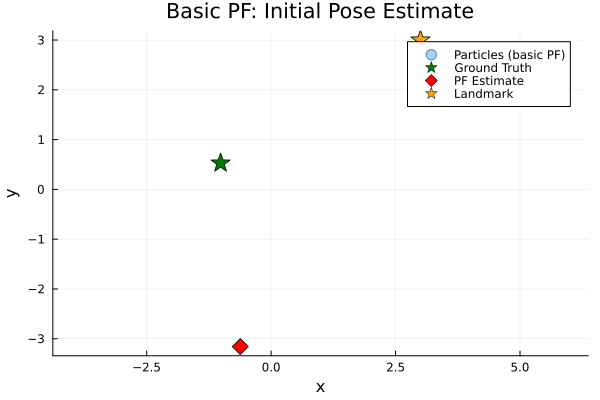

In [94]:
# Visualize basic PF particle distribution
pf_basic_x0 = [tr[:x0] for tr in state_pf_basic.traces]
pf_basic_y0 = [tr[:y0] for tr in state_pf_basic.traces]

p = scatter(pf_basic_x0, pf_basic_y0, 
    alpha=0.4, markersize=4, label="Particles (basic PF)",
    xlabel="x", ylabel="y", 
    title="Basic PF: Initial Pose Estimate",
    aspect_ratio=:equal)

# Ground truth
scatter!(p, [x0_true], [y0_true], 
    markersize=10, color=:green, markershape=:star5, label="Ground Truth")

# PF estimate (mean)
scatter!(p, [x0_pf_basic], [y0_pf_basic], 
    markersize=8, color=:red, markershape=:diamond, label="PF Estimate")

# Landmark
scatter!(p, [LANDMARK_X], [LANDMARK_Y], 
    markersize=10, color=:orange, markershape=:star5, label="Landmark")

display(p)

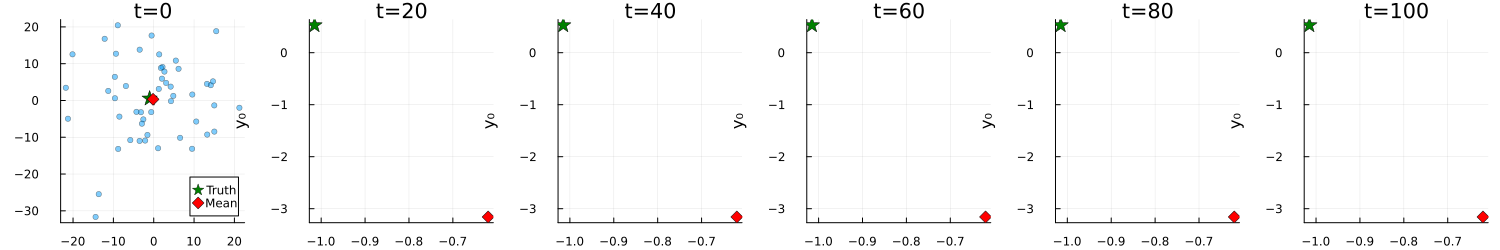

In [95]:
# Track particle evolution over time
function particle_filter_with_history(observations, observations_theta, dt, controls, T, n_particles;
    sigma_v, sigma_omega, sigma_obs, sigma_theta,
    ess_thresh=0.5, save_every=10)
obs_choices = Vector{DynamicChoiceMap}(undef, T + 1)
obs_choices[1] = choicemap((:obs, 0) => observations[1], (:obs_theta, 0) => observations_theta[1])
for t in 1:T
obs_choices[t + 1] = choicemap((:obs, t) => observations[t + 1], (:obs_theta, t) => observations_theta[t + 1])
end

state = pf_initialize(
robot_localization_model,
(dt, controls, 0, sigma_v, sigma_omega, sigma_obs, sigma_theta),
obs_choices[1],
n_particles
)

diffs = (NoChange(), NoChange(), UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())

# Store history: (time, x0_particles, y0_particles)
history = [(0, [tr[:x0] for tr in state.traces], [tr[:y0] for tr in state.traces])]

for t in 1:T
if effective_sample_size(state) < ess_thresh * n_particles
pf_resample!(state, :residual)
end

pf_update!(
state,
(dt, controls, t, sigma_v, sigma_omega, sigma_obs, sigma_theta),
diffs,
obs_choices[t + 1]
)

if t % save_every == 0
push!(history, (t, [tr[:x0] for tr in state.traces], [tr[:y0] for tr in state.traces]))
end
end

return state, history
end

Random.seed!(420)
_, pf_history = particle_filter_with_history(observations, observations_theta, dt, controls, T, 50;
sigma_v=sigma_v, sigma_omega=sigma_omega, sigma_obs=sigma_obs, sigma_theta=sigma_theta, save_every=T÷5)

# Plot evolution as subplots
n_snapshots = length(pf_history)
p = plot(layout=(1, n_snapshots), size=(250*n_snapshots, 250), 
title="Particle Filter Evolution: x0 estimates over time")

for (i, (t, xs, ys)) in enumerate(pf_history)
scatter!(p[i], xs, ys, alpha=0.5, markersize=3, label="", 
xlabel="x₀", ylabel="y₀", title="t=$t")
scatter!(p[i], [x0_true], [y0_true], markersize=8, color=:green, 
markershape=:star5, label=(i==1 ? "Truth" : ""))
scatter!(p[i], [mean(xs)], [mean(ys)], markersize=6, color=:red, 
markershape=:diamond, label=(i==1 ? "Mean" : ""))
end

display(p)

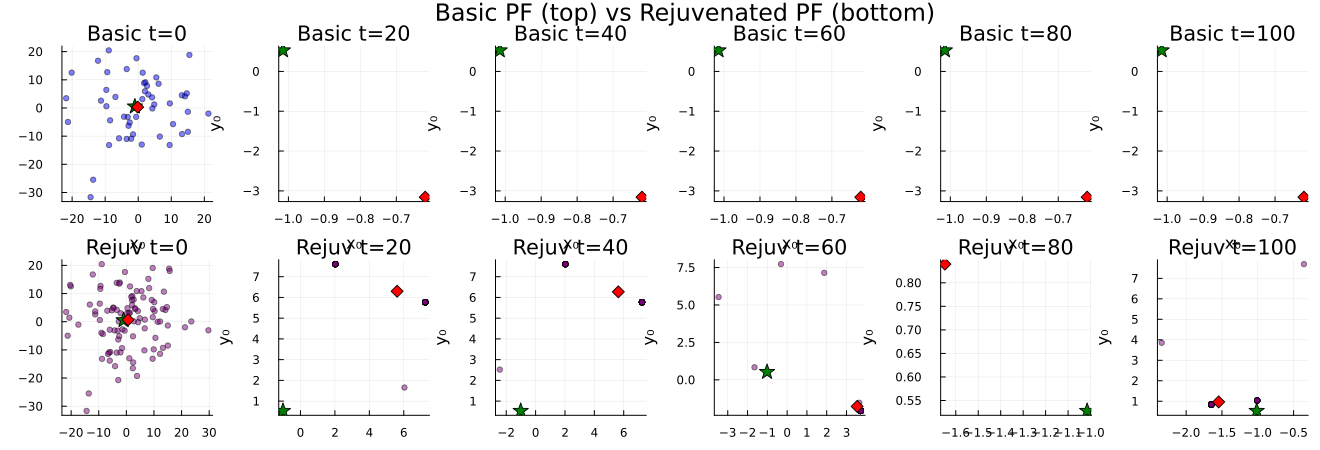

In [96]:
# Compare: Rejuvenated PF evolution
function particle_filter_rejuv_with_history(observations, observations_theta, dt, controls, T, n_particles;
                                            sigma_v, sigma_omega, sigma_obs, sigma_theta,
                                            ess_thresh=0.5, save_every=10,
                                            rejuv_pose_steps=3, rejuv_noise_steps=1, rejuv_noise_window=25)
    obs_choices = Vector{DynamicChoiceMap}(undef, T + 1)
    obs_choices[1] = choicemap((:obs, 0) => observations[1], (:obs_theta, 0) => observations_theta[1])
    for t in 1:T
        obs_choices[t + 1] = choicemap((:obs, t) => observations[t + 1], (:obs_theta, t) => observations_theta[t + 1])
    end

    state = pf_initialize(
        robot_localization_model,
        (dt, controls, 0, sigma_v, sigma_omega, sigma_obs, sigma_theta),
        obs_choices[1],
        n_particles
    )

    diffs = (NoChange(), NoChange(), UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())
    history = [(0, [tr[:x0] for tr in state.traces], [tr[:y0] for tr in state.traces])]

    for t in 1:T
        if effective_sample_size(state) < ess_thresh * n_particles
            pf_resample!(state, :residual)
            # MCMC rejuvenation to restore diversity
            for _ in 1:rejuv_pose_steps
                pf_rejuvenate!(state, mh, (pose_sel,))
            end
            if rejuv_noise_steps > 0 && rejuv_noise_window > 0
                t0 = max(1, t - rejuv_noise_window + 1)
                ns = noise_sel(t0:t)
                for _ in 1:rejuv_noise_steps
                    pf_rejuvenate!(state, mh, (ns,))
                end
            end
        end

        pf_update!(state, (dt, controls, t, sigma_v, sigma_omega, sigma_obs, sigma_theta), diffs, obs_choices[t + 1])
        
        if t % save_every == 0
            push!(history, (t, [tr[:x0] for tr in state.traces], [tr[:y0] for tr in state.traces]))
        end
    end
    return state, history
end

Random.seed!(420)
_, pf_rejuv_history = particle_filter_rejuv_with_history(observations, observations_theta, dt, controls, T, 100;
    sigma_v=sigma_v, sigma_omega=sigma_omega, sigma_obs=sigma_obs, sigma_theta=sigma_theta, save_every=T÷5)

# Side-by-side comparison
n_snapshots = min(length(pf_history), length(pf_rejuv_history))
p = plot(layout=(2, n_snapshots), size=(220*n_snapshots, 450))

for (i, (t, xs, ys)) in enumerate(pf_history[1:n_snapshots])
    scatter!(p[1,i], xs, ys, alpha=0.5, markersize=3, label="", color=:blue,
             xlabel="x₀", ylabel="y₀", title="Basic t=$t")
    scatter!(p[1,i], [x0_true], [y0_true], markersize=8, color=:green, markershape=:star5, label="")
    scatter!(p[1,i], [mean(xs)], [mean(ys)], markersize=6, color=:red, markershape=:diamond, label="")
end

for (i, (t, xs, ys)) in enumerate(pf_rejuv_history[1:n_snapshots])
    scatter!(p[2,i], xs, ys, alpha=0.5, markersize=3, label="", color=:purple,
             xlabel="x₀", ylabel="y₀", title="Rejuv t=$t")
    scatter!(p[2,i], [x0_true], [y0_true], markersize=8, color=:green, markershape=:star5, label="")
    scatter!(p[2,i], [mean(xs)], [mean(ys)], markersize=6, color=:red, markershape=:diamond, label="")
end

plot!(p, plot_title="Basic PF (top) vs Rejuvenated PF (bottom)")
display(p)

In [ ]:
# IMPROVED Particle Filter - addresses early collapse
# Key fixes:
# 1. Delay first resampling to let motion accumulate
# 2. More aggressive rejuvenation with random-walk proposals
# 3. More particles
# 4. Lower ESS threshold

function improved_particle_filter(
    observations, observations_theta, dt, controls, T, n_particles;
    sigma_v, sigma_omega, sigma_obs, sigma_theta,
    ess_thresh=0.3,                # Lower threshold - resample less often
    min_steps_before_resample=20,  # Let motion accumulate first!
    rejuv_steps=10,                # More rejuvenation
    σ_x_prop=1.0,                  # Random walk proposal std for x,y
    σ_θ_prop=0.3                   # Random walk proposal std for θ
)
    obs_choices = Vector{DynamicChoiceMap}(undef, T + 1)
    obs_choices[1] = choicemap((:obs, 0) => observations[1], (:obs_theta, 0) => observations_theta[1])
    for t in 1:T
        obs_choices[t + 1] = choicemap((:obs, t) => observations[t + 1], (:obs_theta, t) => observations_theta[t + 1])
    end

    state = pf_initialize(
        robot_localization_model,
        (dt, controls, 0, sigma_v, sigma_omega, sigma_obs, sigma_theta),
        obs_choices[1],
        n_particles
    )

    diffs = (NoChange(), NoChange(), UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())
    
    n_resamples = 0

    for t in 1:T
        ess = effective_sample_size(state)
        
        # Only resample after enough steps AND when ESS is low
        if t >= min_steps_before_resample && ess < ess_thresh * n_particles
            pf_resample!(state, :residual)
            n_resamples += 1
            
            # Aggressive rejuvenation with RANDOM WALK proposals (not prior)
            for _ in 1:rejuv_steps
                for i in 1:n_particles
                    tr = state.traces[i]
                    
                    # Propose random walk perturbation
                    x0_curr = tr[:x0]
                    y0_curr = tr[:y0]
                    θ0_curr = tr[:theta0]
                    
                    x0_prop = x0_curr + σ_x_prop * randn()
                    y0_prop = y0_curr + σ_x_prop * randn()
                    θ0_prop = rem2pi(θ0_curr + σ_θ_prop * randn(), RoundNearest)
                    
                    # MH update with constraint
                    proposal = choicemap(:x0 => x0_prop, :y0 => y0_prop, :theta0 => θ0_prop)
                    (new_tr, w, _, _) = update(tr, get_args(tr), map(_ -> NoChange(), get_args(tr)), proposal)
                    
                    # Accept/reject (symmetric proposal, so just weight ratio)
                    if log(rand()) < w
                        state.traces[i] = new_tr
                    end
                end
            end
        end

        pf_update!(state, (dt, controls, t, sigma_v, sigma_omega, sigma_obs, sigma_theta), diffs, obs_choices[t + 1])

        if t % (T÷5) == 0
            xs = [tr[:x0] for tr in state.traces]
            println("t=$t: ESS=$(round(ess,digits=1)), unique=$(length(unique(round.(xs, digits=1)))), " *
                    "x0=$(round(mean(state,:x0),digits=2)), y0=$(round(mean(state,:y0),digits=2))")
        end
    end
    
    println("Total resamples: $n_resamples")
    return state
end

# Run improved PF
Random.seed!(420)
state_improved = improved_particle_filter(observations, observations_theta, dt, controls, T, 200;
    sigma_v=sigma_v, sigma_omega=sigma_omega, sigma_obs=sigma_obs, sigma_theta=sigma_theta,
    min_steps_before_resample=20,  # Key: wait for motion info
    ess_thresh=0.3,
    rejuv_steps=10,
    σ_x_prop=0.5,
    σ_θ_prop=0.2
)

x0_improved = mean(state_improved, :x0)
y0_improved = mean(state_improved, :y0)
theta0_improved = mean(state_improved, :theta0)

println("\nImproved PF Results:")
println("x0: $(round(x0_improved, digits=3)) (true: $(round(x0_true, digits=3)))")
println("y0: $(round(y0_improved, digits=3)) (true: $(round(y0_true, digits=3)))")
println("θ0: $(round(theta0_improved, digits=3)) (true: $(round(theta0_true, digits=3)))")
err = sqrt((x0_improved-x0_true)^2 + (y0_improved-y0_true)^2 + (theta0_improved-theta0_true)^2)
println("RMSE: $(round(err, digits=3))")

t=4: ESS=3.0, unique=160, x0=1.56, y0=6.39
t=8: ESS=3.1, unique=160, x0=1.39, y0=5.95
t=12: ESS=1.2, unique=160, x0=2.21, y0=7.25
t=16: ESS=3.5, unique=160, x0=2.26, y0=2.41
t=20: ESS=2.3, unique=26, x0=3.91, y0=2.26
Total resamples: 1

Improved PF Results:
x0: 3.906 (true: -1.015)
y0: 2.258 (true: 0.528)
θ0: 1.046 (true: -1.205)
RMSE: 5.681


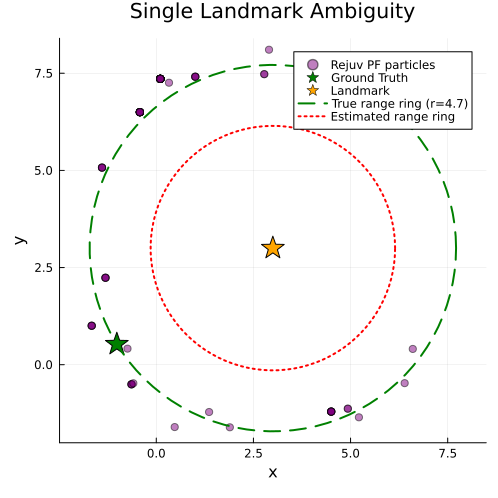

In [80]:
# Visualize the geometric ambiguity: ring of constant range to landmark
p = scatter(pf_rejuv_history[end][2], pf_rejuv_history[end][3], 
    alpha=0.5, markersize=4, label="Rejuv PF particles", color=:purple,
    xlabel="x", ylabel="y", title="Single Landmark Ambiguity",
    aspect_ratio=:equal, size=(500, 500))

# Ground truth
scatter!(p, [x0_true], [y0_true], markersize=12, color=:green, markershape=:star5, label="Ground Truth")

# Landmark
scatter!(p, [LANDMARK_X], [LANDMARK_Y], markersize=12, color=:orange, markershape=:star5, label="Landmark")

# Draw the ring of ambiguity: all points at true initial range from landmark
true_range = sqrt((LANDMARK_X - x0_true)^2 + (LANDMARK_Y - y0_true)^2)
θs = range(0, 2π, length=100)
ring_x = LANDMARK_X .+ true_range .* cos.(θs)
ring_y = LANDMARK_Y .+ true_range .* sin.(θs)
plot!(p, ring_x, ring_y, linewidth=2, color=:green, linestyle=:dash, 
      label="True range ring (r=$(round(true_range, digits=1)))")

# Estimated range ring
est_range = sqrt((LANDMARK_X - mean(pf_rejuv_history[end][2]))^2 + (LANDMARK_Y - mean(pf_rejuv_history[end][3]))^2)
ring_x_est = LANDMARK_X .+ est_range .* cos.(θs)
ring_y_est = LANDMARK_Y .+ est_range .* sin.(θs)
plot!(p, ring_x_est, ring_y_est, linewidth=2, color=:red, linestyle=:dot,
      label="Estimated range ring")

annotate!(p, [(0, -15, text("With 1 landmark, ANY point on the ring\nis equally consistent with the range observation!", 8, :center))])

display(p)

In [ ]:
# Demonstrate: Multiple (position, heading) pairs produce similar range sequences
# This is WHY single-landmark localization is fundamentally hard

function simulate_range_sequence(x0, y0, θ0, v_trace, ω_trace, T_sim)
    ranges = Float64[]
    x, y, θ = x0, y0, θ0
    push!(ranges, sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2))
    
    for t in 1:T_sim
        θ = rem2pi(θ + ω_trace[t] * dt, RoundNearest)
        x += v_trace[t] * cos(θ) * dt
        y += v_trace[t] * sin(θ) * dt
        push!(ranges, sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2))
    end
    return ranges
end

# Get the actual noise from the trace
v_noise = [trace[(:v_noise, t)] for t in 1:T]
ω_noise = [trace[(:omega_noise, t)] for t in 1:T]

# True trajectory
true_seq = simulate_range_sequence(x0_true, y0_true, theta0_true, v_noise, ω_noise, T)

# Find alternative starting points that produce similar range sequences
# Try points on the initial ring with different headings
init_r = sqrt((LANDMARK_X - x0_true)^2 + (LANDMARK_Y - y0_true)^2)
base_angle = atan(y0_true - LANDMARK_Y, x0_true - LANDMARK_X)

best_alternatives = []
for angle_offset in range(0.5, 2π-0.5, length=20)  # Different positions on ring
    for θ_offset in range(-π, π, length=20)  # Different headings
        alt_x0 = LANDMARK_X + init_r * cos(base_angle + angle_offset)
        alt_y0 = LANDMARK_Y + init_r * sin(base_angle + angle_offset)
        alt_θ0 = theta0_true + θ_offset
        
        alt_seq = simulate_range_sequence(alt_x0, alt_y0, alt_θ0, v_noise, ω_noise, T)
        
        # How well does this match the true range sequence?
        mse = mean((alt_seq .- true_seq).^2)
        push!(best_alternatives, (mse, alt_x0, alt_y0, alt_θ0, alt_seq))
    end
end

sort!(best_alternatives, by=x->x[1])

# Plot the best matching alternatives
p1 = plot(0:T, true_seq, label="True", linewidth=3, color=:green,
          xlabel="Time", ylabel="Range", title="Multiple hypotheses match the data!")

colors = [:red, :blue, :orange, :purple]
for (i, (mse, ax, ay, aθ, aseq)) in enumerate(best_alternatives[2:5])  # Skip first (it's the true one)
    plot!(p1, 0:T, aseq, label="Alt $i (MSE=$(round(mse, digits=2)))", 
          linewidth=2, linestyle=:dash, color=colors[i])
end

# Show where these alternatives are located
p2 = scatter([x0_true], [y0_true], markersize=12, color=:green, markershape=:star5,
             label="True start", xlabel="x", ylabel="y", title="Starting positions",
             aspect_ratio=:equal)
scatter!(p2, [LANDMARK_X], [LANDMARK_Y], markersize=10, color=:orange, markershape=:star5, label="Landmark")

# Draw heading arrows
quiver!(p2, [x0_true], [y0_true], quiver=([2*cos(theta0_true)], [2*sin(theta0_true)]), 
        color=:green, linewidth=2)

for (i, (mse, ax, ay, aθ, _)) in enumerate(best_alternatives[2:5])
    scatter!(p2, [ax], [ay], markersize=8, color=colors[i], label="Alt $i")
    quiver!(p2, [ax], [ay], quiver=([2*cos(aθ)], [2*sin(aθ)]), color=colors[i], linewidth=2)
end

# Draw initial ring
θs = range(0, 2π, length=100)
plot!(p2, LANDMARK_X .+ init_r .* cos.(θs), LANDMARK_Y .+ init_r .* sin.(θs), 
      color=:gray, linestyle=:dash, label="Initial range ring")

plot(p1, p2, layout=(1,2), size=(1000, 400))


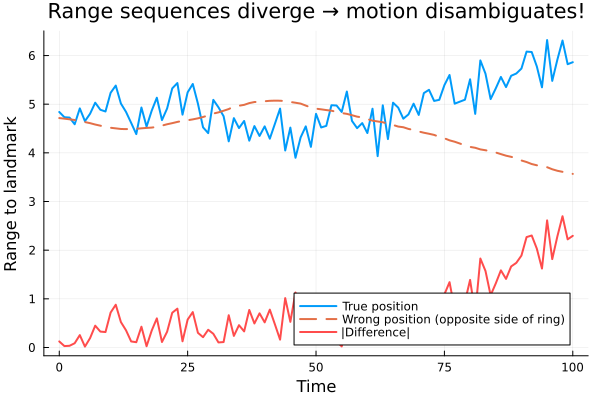

Initial range (both): 4.84 vs 4.72
Final range: true=5.86, wrong=3.57
Max divergence: 2.7m


In [79]:
# Demonstrate: Range changes SHOULD disambiguate position
# Compare range sequences from true position vs a wrong position on the same initial ring

# True trajectory
true_ranges = observations
T_actual = length(observations) - 1  # Get actual T from observations

# True initial range to landmark
init_range = sqrt((LANDMARK_X - x0_true)^2 + (LANDMARK_Y - y0_true)^2)

# Hypothetical wrong starting position (same initial range, different location)
# Pick a point on the opposite side of the ring
θ_offset = π  # opposite side
angle_to_true = atan(y0_true - LANDMARK_Y, x0_true - LANDMARK_X)
wrong_x0 = LANDMARK_X + init_range * cos(angle_to_true + θ_offset)
wrong_y0 = LANDMARK_Y + init_range * sin(angle_to_true + θ_offset)

# Simulate trajectory from wrong starting point with SAME controls/noise
function simulate_ranges_from(x0, y0, θ0, trace, T_sim)
    ranges = Float64[]
    x, y, θ = x0, y0, θ0
    push!(ranges, sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2))
    
    for t in 1:T_sim
        θ = rem2pi(θ + trace[(:omega_noise, t)] * dt, RoundNearest)
        x += trace[(:v_noise, t)] * cos(θ) * dt
        y += trace[(:v_noise, t)] * sin(θ) * dt
        push!(ranges, sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2))
    end
    return ranges
end

wrong_ranges = simulate_ranges_from(wrong_x0, wrong_y0, theta0_true, trace, T_actual)

p = plot(0:T_actual, true_ranges, label="True position", linewidth=2, 
         xlabel="Time", ylabel="Range to landmark",
         title="Range sequences diverge → motion disambiguates!")
plot!(p, 0:T_actual, wrong_ranges, label="Wrong position (opposite side of ring)", linewidth=2, linestyle=:dash)
plot!(p, 0:T_actual, abs.(true_ranges .- wrong_ranges), label="|Difference|", linewidth=2, color=:red, alpha=0.7)

display(p)

println("Initial range (both): $(round(true_ranges[1], digits=2)) vs $(round(wrong_ranges[1], digits=2))")
println("Final range: true=$(round(true_ranges[end], digits=2)), wrong=$(round(wrong_ranges[end], digits=2))")
println("Max divergence: $(round(maximum(abs.(true_ranges .- wrong_ranges)), digits=2))m")

In [ ]:
# Selection helpers
pose_sel = select(:x0, :y0, :theta0)

function noise_sel(ts)
    addrs = Any[]
    for t in ts
        push!(addrs, (:v_noise, t))
        push!(addrs, (:omega_noise, t))
    end
    return select(addrs...)
end

function particle_filter_localization_rejuvenated(
    observations, observations_theta, dt, controls, T, n_particles;
    sigma_v, sigma_omega, sigma_obs, sigma_theta,
    ess_thresh=0.5,
    rejuv_pose_steps=3,          # MH steps on (x0,y0,theta0) after resampling
    rejuv_noise_steps=1,         # MH steps on recent noise after resampling
    rejuv_noise_window=25        # how many latest timesteps of noise to rejuvenate
)
    @assert length(observations) == T + 1
    @assert size(controls, 1) >= T
    @assert size(controls, 2) == 2

    # obs constraints (range + heading)
    obs_choices = Vector{DynamicChoiceMap}(undef, T + 1)
    obs_choices[1] = choicemap((:obs, 0) => observations[1], (:obs_theta, 0) => observations_theta[1])
    for t in 1:T
        obs_choices[t + 1] = choicemap((:obs, t) => observations[t + 1], (:obs_theta, t) => observations_theta[t + 1])
    end

    # init at T=0
    state = pf_initialize(
        robot_localization_model,
        (dt, controls, 0, sigma_v, sigma_omega, sigma_obs, sigma_theta),
        obs_choices[1],
        n_particles
    )

    # only the 3rd argument (T) changes
    diffs = (NoChange(), NoChange(), UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())

    for t in 1:T
        if effective_sample_size(state) < ess_thresh * n_particles
            pf_resample!(state, :residual)

            # --- rejuvenation to fight path degeneracy ---
            for _ in 1:rejuv_pose_steps
                pf_rejuvenate!(state, mh, (pose_sel,))
            end

            if rejuv_noise_steps > 0 && rejuv_noise_window > 0
                t0 = max(1, t - rejuv_noise_window + 1)
                ns = noise_sel(t0:t)
                for _ in 1:rejuv_noise_steps
                    pf_rejuvenate!(state, mh, (ns,))
                end
            end
        end

        pf_update!(
            state,
            (dt, controls, t, sigma_v, sigma_omega, sigma_obs, sigma_theta),
            diffs,
            obs_choices[t + 1]
        )

        if t % 100 == 0
            xs = [tr[:x0] for tr in state.traces]
            println("PF Time $t: x0=$(round(mean(state,:x0),digits=3)), y0=$(round(mean(state,:y0),digits=3)), θ0=$(round(mean(state,:theta0),digits=3))  |  ESS=$(round(effective_sample_size(state),digits=1))  unique_x0=$(length(unique(xs)))")
        end
    end

    return state
end

Random.seed!(420)

state_pf = particle_filter_localization_rejuvenated(
    observations, observations_theta, dt, controls, T, 100;
    sigma_v=sigma_v, sigma_omega=sigma_omega, sigma_obs=sigma_obs, sigma_theta=sigma_theta,
    ess_thresh=0.5,
    rejuv_pose_steps=3,
    rejuv_noise_steps=1,
    rejuv_noise_window=25
)

x0_pf     = mean(state_pf, :x0)
y0_pf     = mean(state_pf, :y0)
theta0_pf = mean(state_pf, :theta0)

println("\nParticle Filter Results:")
println("x0: mean=$(round(x0_pf, digits=3)), true=$(round(x0_true, digits=3))")


PF Time 100: x0=7.032, y0=2.793, θ0=1.037  |  ESS=91.2  unique_x0=4

Particle Filter Results:
x0: mean=7.032, true=-1.015


# Comparison

In [30]:
# Summary comparison - ALL methods estimate INITIAL POSE
println("=" ^ 70)
println("INFERENCE RESULTS COMPARISON")
println("All methods estimate p(x0, y0, θ0 | z_{0:T})")
println("=" ^ 70)

println("\nGround Truth: x0=$(round(x0_true, digits=3)), y0=$(round(y0_true, digits=3)), θ0=$(round(theta0_true, digits=3))")

println("\n1. MH (blocked updates):")
mh_x0 = mean(mh_samples_x0)
mh_y0 = mean(mh_samples_y0)
mh_theta0 = mean(mh_samples_theta0)
mh_err = sqrt((mh_x0-x0_true)^2 + (mh_y0-y0_true)^2 + (mh_theta0-theta0_true)^2)
println("  Estimate: x0=$(round(mh_x0, digits=3)), y0=$(round(mh_y0, digits=3)), θ0=$(round(mh_theta0, digits=3))")
println("  Std: x0=$(round(std(mh_samples_x0), digits=3)), y0=$(round(std(mh_samples_y0), digits=3)), θ0=$(round(std(mh_samples_theta0), digits=3))")
println("  RMSE: $(round(mh_err, digits=3))")

println("\n2. IS (importance sampling):")
is_err = sqrt((x0_is-x0_true)^2 + (y0_is-y0_true)^2 + (theta0_is-theta0_true)^2)
println("  Estimate: x0=$(round(x0_is, digits=3)), y0=$(round(y0_is, digits=3)), θ0=$(round(theta0_is, digits=3))")
println("  Std: x0=$(round(std(is_samples_x0), digits=3)), y0=$(round(std(is_samples_y0), digits=3)), θ0=$(round(std(is_samples_theta0), digits=3))")
println("  RMSE: $(round(is_err, digits=3))")

println("\n3. PF (basic, no rejuvenation):")
pf_basic_samples_x0 = [tr[:x0] for tr in state_pf_basic.traces]
pf_basic_samples_y0 = [tr[:y0] for tr in state_pf_basic.traces]
pf_basic_samples_theta0 = [tr[:theta0] for tr in state_pf_basic.traces]
pf_basic_err = sqrt((x0_pf_basic-x0_true)^2 + (y0_pf_basic-y0_true)^2 + (theta0_pf_basic-theta0_true)^2)
println("  Estimate: x0=$(round(x0_pf_basic, digits=3)), y0=$(round(y0_pf_basic, digits=3)), θ0=$(round(theta0_pf_basic, digits=3))")
println("  Std: x0=$(round(std(pf_basic_samples_x0), digits=3)), y0=$(round(std(pf_basic_samples_y0), digits=3)), θ0=$(round(std(pf_basic_samples_theta0), digits=3))")
println("  RMSE: $(round(pf_basic_err, digits=3))")

println("\n4. PF (with rejuvenation):")
pf_samples_x0 = [tr[:x0] for tr in state_pf.traces]
pf_samples_y0 = [tr[:y0] for tr in state_pf.traces]
pf_samples_theta0 = [tr[:theta0] for tr in state_pf.traces]
pf_err = sqrt((x0_pf-x0_true)^2 + (y0_pf-y0_true)^2 + (theta0_pf-theta0_true)^2)
println("  Estimate: x0=$(round(x0_pf, digits=3)), y0=$(round(y0_pf, digits=3)), θ0=$(round(theta0_pf, digits=3))")
println("  Std: x0=$(round(std(pf_samples_x0), digits=3)), y0=$(round(std(pf_samples_y0), digits=3)), θ0=$(round(std(pf_samples_theta0), digits=3))")
println("  RMSE: $(round(pf_err, digits=3))")

println("\n" * "=" ^ 70)
errors = [("MH", mh_err), ("IS", is_err), ("PF basic", pf_basic_err), ("PF rejuv", pf_err)]
sort!(errors, by=x->x[2])
println("Ranking (best to worst):")
for (i, (name, err)) in enumerate(errors)
    println("  $i. $name: RMSE = $(round(err, digits=3))")
end
println("=" ^ 70)

INFERENCE RESULTS COMPARISON
All methods estimate p(x0, y0, θ0 | z_{0:T})

Ground Truth: x0=-1.015, y0=0.528, θ0=-1.205

1. MH (blocked updates):
  Estimate: x0=5.955, y0=-0.654, θ0=0.651
  Std: x0=1.854, y0=0.761, θ0=1.05
  RMSE: 7.309

2. IS (importance sampling):
  Estimate: x0=-1.799, y0=4.225, θ0=4.36
  Std: x0=0.0, y0=0.0, θ0=0.0
  RMSE: 6.727

3. PF (basic, no rejuvenation):
  Estimate: x0=2.657, y0=7.855, θ0=-4.025
  Std: x0=0.982, y0=1.548, θ0=0.168
  RMSE: 8.667

4. PF (with rejuvenation):
  Estimate: x0=7.032, y0=2.793, θ0=1.037
  Std: x0=2.394, y0=1.312, θ0=1.04
  RMSE: 8.655

Ranking (best to worst):
  1. IS: RMSE = 6.727
  2. MH: RMSE = 7.309
  3. PF rejuv: RMSE = 8.655
  4. PF basic: RMSE = 8.667
